<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/clusters/07_RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
warnings.filterwarnings('ignore')

In [3]:
def porcentaje_nulos_x_caracteristica(data:pd.DataFrame, **kwargs)->None:
  """Calcular el porcentaje de valores nulos por caracteristicas"""
  data.isnull().melt().pipe(
        lambda df: (
            sns.displot(
                data=df,
                y='variable',
                hue='value',
                multiple='fill',
                aspect=2
            ).set(**kwargs)
        )
    )

def pie_circle(
    serie:pd.Series,
    paleta=None,
    figsize_x:int=7,
    figsize_y:int=7,
    fontsize=15,
    **kwards)->None:
  """Grafica un anillo"""
  paleta = paleta if paleta !=None else generate_colors()[0]
  values = serie.value_counts().sort_index()
  names = values.index
  size = values.values
  fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
  fig.suptitle(f'Diagrama de anillo {kwards["title"]}', fontsize=fontsize)
  my_circle = plt.Circle( (0,0), 0.7, color='white')
  plt.pie(
      size,
      labels=names,
      autopct="%0.1f %%",
      wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
      colors = paleta)
  p = plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()


# **Config**
---

In [4]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
title_data = 'RFM Analysis'
paleta = sns.color_palette('Set2').as_hex()
random_seed=12354

# **Data**
---

In [5]:
url_rfm = 'https://drive.google.com/file/d/1zbcIsgKYhhErE-4mnylbWIR1rSu9w1Li/view?usp=sharing'
url_rfm = 'https://drive.google.com/uc?id=' + url_rfm.split('/')[-2]
data_rfm = pd.read_csv(url_rfm, dtype='str', encoding='latin')

Names of columns are normalized

In [6]:
norm_columns = [
    'invoice_no',
    'stock_code',
    'description',
    'quantity',
    'invoice_date',
    'unit_price',
    'customer_id',
    'country'
]

data_rfm.columns = norm_columns

In [7]:
data_rfm.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Real data type are assigned to the data

In [8]:
# Type Change
data_rfm[
    ['quantity', 'unit_price']
    ] = data_rfm[
        ['quantity', 'unit_price']
        ].astype('float64')

data_rfm['invoice_date'] = pd.to_datetime(data_rfm['invoice_date'])

In [9]:
# info
data_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  float64       
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  object        
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 33.1+ MB


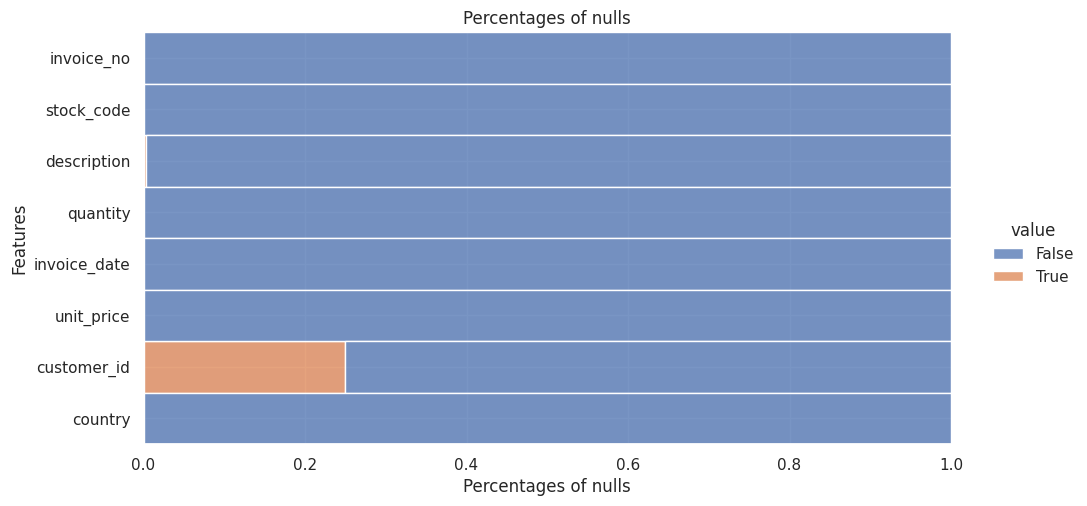

In [10]:
# inspect data null
porcentaje_nulos_x_caracteristica(data_rfm, title="Percentages of nulls", xlabel='Percentages of nulls', ylabel='Features')

In [11]:
data_rfm.shape

(541909, 8)

- The set has 541909 customer_id null values (25%)
- The set has 1454 description null values (0.26%)
- The set has five object type features: invoice_no, stock_code, description, customer_id and country

For the purposes of this exercise, null values corresponding to customer identification (Customer ID) are disregarded, as imputing such values could introduce bias into the model by assuming that purchases could have been made by other customers.

In [12]:
data_rfm = data_rfm[data_rfm['customer_id'].notnull()]
data_rfm.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.00,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00,2010-12-01 08:26:00,3.39,17850,United Kingdom


# **Preprocessing**
---

The quantity sold cannot be negative or cero because it doesn't make sense

In [13]:
data_rfm = data_rfm[data_rfm['quantity'] > 0]

The recent date by which a customer makes the purchase.

In [14]:
data_rfm['invoice_date'].max()

Timestamp('2011-12-09 12:50:00')

The total days of purchases in the set.

In [15]:
total_days = data_rfm['invoice_date'].max() - data_rfm['invoice_date'].min()
total_days = total_days.days
total_days

373

 Multiply the unit price with quantity, for calculate the final price

In [16]:
data_rfm['cost_total'] = data_rfm['quantity'] * data_rfm['unit_price']

In [17]:
data_rfm.shape

(397924, 9)

In [18]:
data_rfm.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,cost_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.00,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


Is use the most recent date that a customer makes the purchase.

In [19]:
date_reference = data_rfm['invoice_date'].max()


function_dictionary = {
    'invoice_date': lambda x: (date_reference-x.max()).days, # Frecuency
    'invoice_no': ['nunique'],
    'cost_total' : ['sum']
}

data_group_rfm = data_rfm.groupby('customer_id').aggregate(
    function_dictionary
).reset_index()
data_group_rfm
data_group_rfm.columns = ['customer_id', 'recency_days', 'frequency', 'monetary']
data_group_rfm.sort_values(by='recency_days')
data_group_rfm

,customer_id,recency_days,frequency,monetary
0,12346,325,1,"77,183.60"
1,12347,1,7,"4,310.00"
2,12348,74,4,"1,797.24"
3,12349,18,1,"1,757.55"
4,12350,309,1,334.40
...,...,...,...,...
4334,18280,277,1,180.60
4335,18281,180,1,80.82
4336,18282,7,2,178.05
4337,18283,3,16,"2,094.88"


- Customer ID: id customer
- Recency: calculation in days that recently the customer has visited the store
- Frequency: Number of invoices the customer has accumulated
moneda: Amount total of purchases

In [20]:
data_group_rfm.describe()

,recency_days,frequency,monetary
count,"4,339.00","4,339.00","4,339.00"
mean,91.52,4.27,"2,053.79"
std,100.01,7.71,"8,988.25"
min,0.00,1.00,0.00
25%,17.00,1.00,307.25
50%,50.00,2.00,674.45
75%,141.00,5.00,"1,661.64"
max,373.00,210.00,"280,206.02"


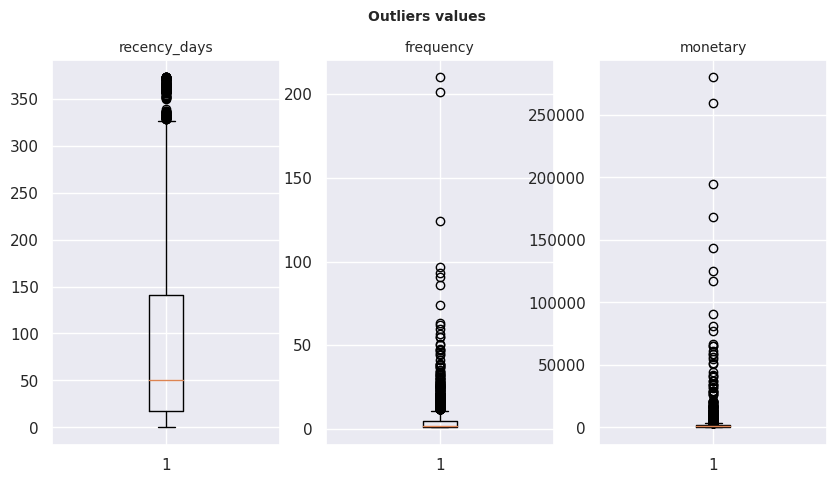

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
dtColumns = data_group_rfm.columns[1:]
for i, colum in enumerate(dtColumns):
  ax[i].boxplot(data_group_rfm[colum])
  ax[i].set_title(colum, fontsize=10)
fig.suptitle('Outliers values', fontsize = 10, fontweight = "bold");

<Axes: xlabel='recency_days', ylabel='frequency'>

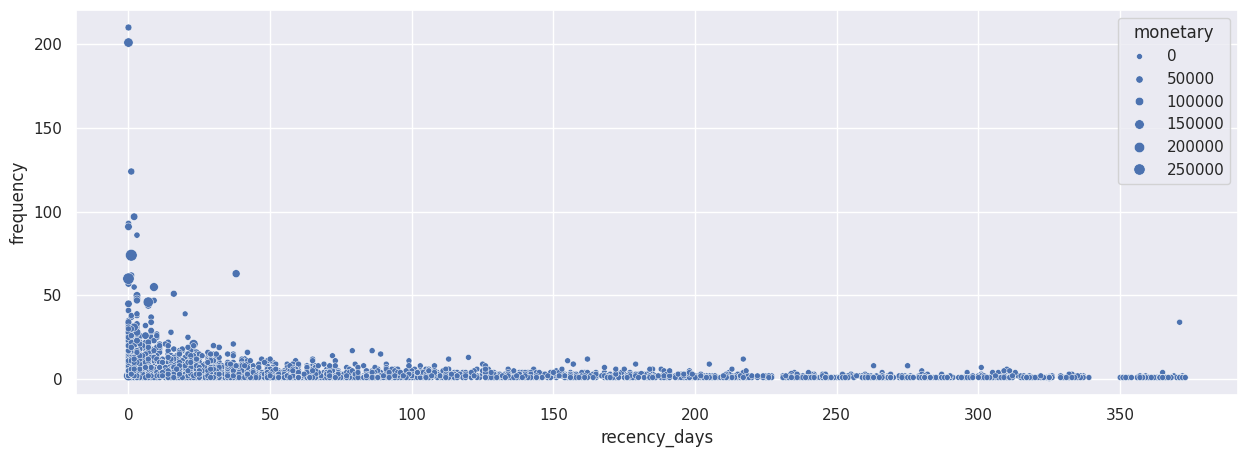

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))
sns.scatterplot(x = "recency_days", y = "frequency", data = data_group_rfm, size='monetary')


In [23]:
data_group_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customer_id   4339 non-null   object 
 1   recency_days  4339 non-null   int64  
 2   frequency     4339 non-null   int64  
 3   monetary      4339 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 135.7+ KB


The quantiles of the three RFM characteristics are determined.

In [24]:
quantiles = data_group_rfm.drop(['customer_id'], axis=1).quantile([0.25, 0.5, 0.75, 1])
quantiles

,recency_days,frequency,monetary
0.25,17.00,1.00,307.25
0.50,50.00,2.00,674.45
0.75,141.00,5.00,"1,661.64"
1.00,373.00,210.00,"280,206.02"


Four scales are used: Very high, High, Medium, Low.

In [25]:
def assignment_label(value: float, feature:str, data_quantile):
  """Assigning a label"""
  res = ''
  if  feature == 'recency_days':
    if value <= data_quantile[feature][0.25]:
      res = 'v'
    elif value <= data_quantile[feature][0.5]:
      res = 'h'
    elif value <= data_quantile[feature][0.75]:
      res = 'm'
    else:
      res = "l"
  else:
    if value <= data_quantile[feature][0.25]:
      res = 'l'
    elif value <= data_quantile[feature][0.5]:
      res = 'm'
    elif value <= data_quantile[feature][0.75]:
      res = 'h'
    else:
      res = "v"
  return res


In [26]:
data_group_rfm['recency_q'] = data_group_rfm['recency_days'].apply(
    assignment_label,
    args=('recency_days', quantiles)
)

In [27]:
data_group_rfm['frequency_q'] = data_group_rfm['frequency'].apply(
    assignment_label,
    args=('frequency', quantiles)
)

In [28]:
data_group_rfm['monetary_q'] = data_group_rfm['monetary'].apply(
    assignment_label,
    args=('monetary', quantiles)
)

In [29]:
data_group_rfm

,customer_id,recency_days,frequency,monetary,recency_q,frequency_q,monetary_q
0,12346,325,1,"77,183.60",l,l,v
1,12347,1,7,"4,310.00",v,v,v
2,12348,74,4,"1,797.24",m,h,v
3,12349,18,1,"1,757.55",h,l,v
4,12350,309,1,334.40,l,l,m
...,...,...,...,...,...,...,...
4334,18280,277,1,180.60,l,l,l
4335,18281,180,1,80.82,l,l,l
4336,18282,7,2,178.05,v,m,l
4337,18283,3,16,"2,094.88",v,v,v


The scores of the three RFM characteristics are concatenated.

In [30]:
data_group_rfm['rfm_quantile'] = data_group_rfm['recency_q'] +  data_group_rfm['frequency_q'] + data_group_rfm['monetary_q']
data_group_rfm

,customer_id,recency_days,frequency,monetary,recency_q,frequency_q,monetary_q,rfm_quantile
0,12346,325,1,"77,183.60",l,l,v,llv
1,12347,1,7,"4,310.00",v,v,v,vvv
2,12348,74,4,"1,797.24",m,h,v,mhv
3,12349,18,1,"1,757.55",h,l,v,hlv
4,12350,309,1,334.40,l,l,m,llm
...,...,...,...,...,...,...,...,...
4334,18280,277,1,180.60,l,l,l,lll
4335,18281,180,1,80.82,l,l,l,lll
4336,18282,7,2,178.05,v,m,l,vml
4337,18283,3,16,"2,094.88",v,v,v,vvv


In [31]:
data_group_rfm['rfm_quantile'].unique()

array(['llv', 'vvv', 'mhv', 'hlv', 'llm', 'hvv', 'lll', 'llh', 'hhv',
       'vmh', 'mmm', 'vhh', 'lmm', 'vll', 'hmv', 'mhh', 'hlh', 'vmm',
       'lmh', 'mlv', 'mmh', 'vhv', 'lhv', 'hmm', 'mlm', 'hlm', 'lhm',
       'lmv', 'mlh', 'hhh', 'hll', 'mmv', 'vmv', 'lml', 'mvv', 'hmh',
       'vvh', 'vlh', 'vlm', 'mml', 'hhm', 'hml', 'mhm', 'hvh', 'mll',
       'vhm', 'lvh', 'vml', 'lvv', 'mhl', 'hhl', 'vhl', 'mvh', 'lhh',
       'lhl', 'lvm', 'vlv', 'vvm', 'vvl', 'mvm', 'lvl'], dtype=object)

The main problem is that too many groups are created

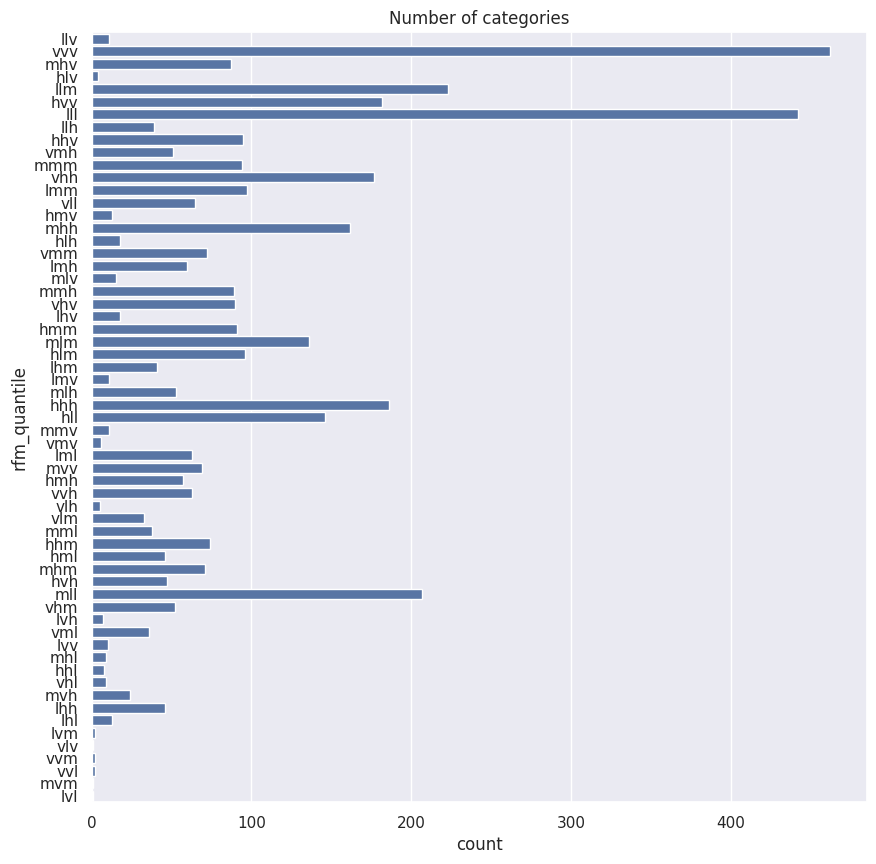

In [32]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10))
ax.set_title('Number of categories')
sns.countplot(y='rfm_quantile', data=data_group_rfm)
plt.show()

In this section of the model, five segments will be considered according to an RFM profile:

- Best customers: Customers who perform the best in terms of purchase frequency, monetary value spent, and recency of their last purchase.
- Big Spender: Customers who have the capacity to make large and frequent purchases.
- Loyal Customer: Customers who make purchases regularly and frequently.
- Inactives: Customers who have not made purchases for a long time and with low frequency.
- Lost Customer: Customers who previously made purchases but no longer do so.
New Customer: Customers who have recently made a purchase.

In [33]:
def customer_segments(value):
    if value in ['vvv', 'hhh']:
      return "Best Customer"
    elif value[1] in ['v', 'h']:
      return "Loyal Customer"
    elif value[2] in ['v', 'h']:
      return "Big Spender"
    elif value == 'lll':
      return "Inactive"
    elif value[0] == 'l' and value[2] == 'l' and value[1] != 'l':
      return "Lost Customer"
    else:
      return "New Customer"



In [34]:
data_group_rfm['cluster'] = data_group_rfm.rfm_quantile.apply(customer_segments)
data_group_rfm.head()

,customer_id,recency_days,frequency,monetary,recency_q,frequency_q,monetary_q,rfm_quantile,cluster
0,12346,325,1,"77,183.60",l,l,v,llv,Big Spender
1,12347,1,7,"4,310.00",v,v,v,vvv,Best Customer
2,12348,74,4,"1,797.24",m,h,v,mhv,Loyal Customer
3,12349,18,1,"1,757.55",h,l,v,hlv,Big Spender
4,12350,309,1,334.40,l,l,m,llm,New Customer


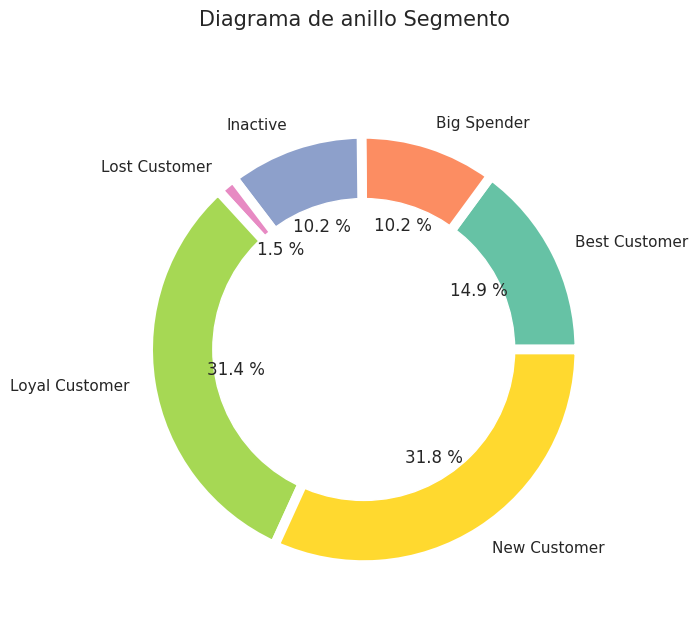

In [35]:
pie_circle(data_group_rfm['cluster'], paleta=paleta, title='Segmento')

In [36]:
c = data_group_rfm[data_group_rfm['cluster'] == 'Lost Customer']
c.head()

,customer_id,recency_days,frequency,monetary,recency_q,frequency_q,monetary_q,rfm_quantile,cluster
85,12450,155,2,197.88,l,m,l,lml,Lost Customer
160,12547,197,2,207.80,l,m,l,lml,Lost Customer
380,12829,336,2,293.00,l,m,l,lml,Lost Customer
430,12897,204,2,216.50,l,m,l,lml,Lost Customer
595,13133,273,2,109.80,l,m,l,lml,Lost Customer


In [37]:
c.describe()

,recency_days,frequency,monetary
count,63.00,63.00,63.00
mean,221.11,2.00,214.63
std,57.05,0.00,67.92
min,149.00,2.00,52.00
25%,183.50,2.00,160.28
50%,202.00,2.00,217.90
75%,257.00,2.00,278.64
max,372.00,2.00,307.02


Numerical values ​​will be in terms of averages.

- The "Best Customer" segment is comprised of 648 (14.19%) customers, who made of 12.59 purchases totaling $7,055.12 dollars 12.99 days ago.

- The "Loyal Customer" segment is comprised of 1362 (31.4%) customers, who made of 5.30 purchases totaling $2,190.50 dollars 57.71 days ago.

- The "Big Spender" segment is comprised of 444 (10.2%) customers, who made of 1.67 purchases totaling $1,787.17 dollars 102.49 days ago.

- The "Inactive" segment is comprised of 442 (10.2%) customers, who made of 1 purchase totaling $165.03 dollars 102.49 days ago.

- The "Lost Customer" segment is comprised of 63 (1.5%) customers, who made of 2 purchases totaling $214.63 dollars 221.11 days ago.

- The "New Customer" segment is comprised of 1,380 (1.5%) customers, who made  of 1.34 purchases totaling $345.12 dollars 96.34 days ago.

While this method of segmentation with broadly identified profiles can yield good results, there is a risk of not being able to analyze behaviors that are not covered by this deterministic approach. It may be necessary to use more robust processes such as machine learning segmentation models.
